In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys

sys.path.append("../..")
from models import RNN

import sklearn.metrics as metrics
from scipy.optimize import minimize
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras import backend as K
import tensorflow.keras.utils as kutils

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

   accuracy  val_accuracy
0  0.555029      0.673077
1  0.600843      0.673077
2  0.600843      0.673077
3  0.600843      0.673077
4  0.600843      0.673077


Text(0, 0.5, 'Accuracy')

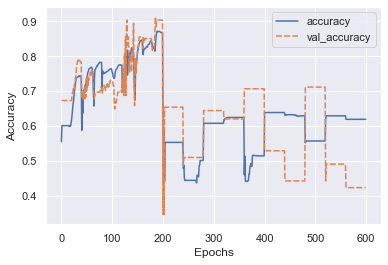

In [62]:
n_epochs = 600
n_models = 15
n_steps = 5
model_prefix = f"RNN-snapshot-{n_steps}-{n_epochs}"

raw_data = pd.read_csv(f'{model_prefix}.csv')
raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
print(raw_data.head())

sns.set_theme()
sns.lineplot(data=raw_data)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

## Ensemble snapshots and produce results 'over_time'


In [63]:
elec = pd.read_csv('../../data/electricity-normalized.csv')
X = elec.values[:,0:8].astype(np.float)
y = elec.values[:,8]
enc = OneHotEncoder(categories=[['DOWN', 'UP']])
y = enc.fit_transform(y.reshape(-1, 1)).toarray()
print(y.shape)

dataset_test = timeseries_dataset_from_array(X, y, sequence_length=n_steps, batch_size=int(0.3 * len(X)), start_index=int(0.7 * len(X)))
X_test, y_test = list(dataset_test)[0]

X_test = X_test.numpy()
y_test = y_test.numpy()

NUM_TESTS=25
nb_classes=2

(45312, 2)


In [65]:
snapshot_model = RNN.create_rnn_model(n_timesteps=n_steps, n_features=8, n_outputs=2)
snapshot_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

file_list =[f'./{model_prefix}/{model_prefix}-{j}-1.h5' for j in range(n_models)]

preds = []
for fn in file_list:
    snapshot_model.load_weights(fn)
    yPreds = snapshot_model.predict(X_test)
    preds.append(yPreds)

    print("Obtained predictions from model with weights = %s" % (fn))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 48)                10944     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 98        
Total params: 11,042
Trainable params: 11,042
Non-trainable params: 0
_________________________________________________________________
Obtained predictions from model with weights = ./RNN-snapshot-5-600/RNN-snapshot-5-600-0-1.h5
Obtained predictions from model with weights = ./RNN-snapshot-5-600/RNN-snapshot-5-600-1-1.h5
Obtained predictions from model with weights = ./RNN-snapshot-5-600/RNN-snapshot-5-600-2-1.h5
Obtained predictions from model with weights = ./RNN-snapshot-5-600/RNN-snapshot-5-600-3-1.h5
Obtained predictions from model with weights = ./RNN-snapshot-5-600/RNN-snapshot-5-600-4-1.h5
Obtained predictions from model with weigh

In [ ]:
print(preds[0]) 

In [67]:
def calculate_weighted_accuracy(prediction_weights):
    weighted_predictions = np.zeros((X_test.shape[0], nb_classes), dtype='float32')
    for weight, prediction in zip(prediction_weights, preds):
        weighted_predictions += weight * prediction
    yPred = enc.inverse_transform(weighted_predictions)
    yTrue = enc.inverse_transform(y_test)
    accuracy = metrics.accuracy_score(yTrue, yPred) * 100
    error = 100 - accuracy
    print("Accuracy: ", accuracy)
    print("Error: ", error)

In [68]:
# Create the loss metric
def log_loss_func(weights):
    ''' scipy minimize will pass the weights as a numpy array '''
    final_prediction = np.zeros((X_test.shape[0], nb_classes), dtype='float32')

    for weight, prediction in zip(weights, preds):
        final_prediction += weight * prediction

    return log_loss(y_test, final_prediction)

In [69]:
def get_accuracy_for_n_snapshots(n_snapshots):
    best_acc = 0.0
    best_weights = None

    # Parameters for optimization
    constraints = ({'type': 'eq', 'fun':lambda w: 1 - sum(w)})
    bounds = [(0, 1)] * n_snapshots

    # Check for NUM_TESTS times
    for iteration in range(NUM_TESTS):
        # Random initialization of weights
        prediction_weights = np.random.random(n_snapshots)
        
        # Minimise the loss 
        result = minimize(log_loss_func, prediction_weights, method='SLSQP', bounds=bounds, constraints=constraints)
        print('Best Ensemble Weights: {weights}'.format(weights=result['x']))
        
        weights = result['x']
        weighted_predictions = np.zeros((X_test.shape[0], nb_classes), dtype='float32')
        
        # Calculate weighted predictions
        for weight, prediction in zip(weights, preds[:n_snapshots]):
            weighted_predictions += weight * prediction

        yPred = enc.inverse_transform(weighted_predictions)
        yTrue = enc.inverse_transform(y_test)

        unique, counts = np.unique(yPred, return_counts=True)
        print(unique, counts)

        # Calculate weight prediction accuracy
        accuracy = metrics.accuracy_score(yTrue, yPred) * 100
        error = 100 - accuracy
        print("Iteration %d: Accuracy : " % (iteration + 1), accuracy)
        print("Iteration %d: Error : " % (iteration + 1), error)
        
        # Save current best weights 
        if accuracy > best_acc:
            best_acc = accuracy
            best_weights = weights
            
        print()

        return accuracy

In [79]:
results = []
for i in range(1, n_models + 1):
    # Compile list of units
    n_snapshots = i
    results.append((i, get_accuracy_for_n_snapshots(i)))

Best Ensemble Weights: [1.]
['DOWN'] [13590]
Iteration 1: Accuracy :  57.01986754966888
Iteration 1: Error :  42.98013245033112

Best Ensemble Weights: [0.62659545 0.37340455]
['DOWN'] [13590]
Iteration 1: Accuracy :  57.01986754966888
Iteration 1: Error :  42.98013245033112

Best Ensemble Weights: [2.02779887e-16 4.64962093e-01 5.35037907e-01]
['DOWN'] [13590]
Iteration 1: Accuracy :  57.01986754966888
Iteration 1: Error :  42.98013245033112

Best Ensemble Weights: [1.73472495e-18 4.32621203e-01 3.07177225e-01 2.60201573e-01]
['DOWN' 'UP'] [9437 4153]
Iteration 1: Accuracy :  54.231052244297274
Iteration 1: Error :  45.768947755702726

Best Ensemble Weights: [0.00000000e+00 3.55904037e-01 4.52104865e-01 1.91931957e-01
 5.91410406e-05]
['DOWN' 'UP'] [13528    62]
Iteration 1: Accuracy :  57.00515084621045
Iteration 1: Error :  42.99484915378955

Best Ensemble Weights: [0.13087094 0.07637112 0.02088313 0.17869535 0.13915073 0.45402873]
['DOWN' 'UP'] [10947  2643]
Iteration 1: Accuracy :

<AxesSubplot:>

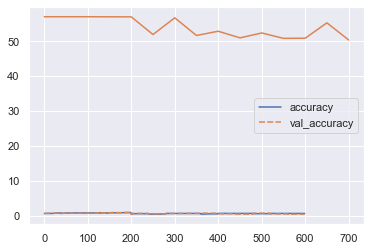

In [74]:
sns.lineplot(data=raw_data)
sns.lineplot(x=(np.arange(1, len(results) + 1) * 50) - 50, y=results)

In [83]:
df = pd.DataFrame(results, columns=['Count', 'Accuracy'])
df.head()


,Count,Accuracy
0,1,57.019868
1,2,57.019868
2,3,57.019868
3,4,54.231052
4,5,57.005151


<AxesSubplot:xlabel='Count', ylabel='Accuracy'>

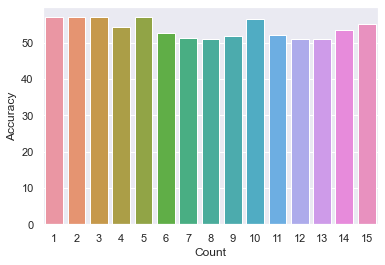

In [87]:
sns.barplot(data=df, x="Count", y="Accuracy")